# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree



# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [2]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape


(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'it', 'won', 'each', 'has', 'for', 'what', "that'll", 'can', 'will', "wasn't", "doesn't", 'have', 'yourselves', 'i', 'they', 'does', 'him', 'herself', 'himself', "isn't", 'very', 'weren', 'doing', "should've", 'to', 'd', "won't", 'few', 'same', 'did', 'ourselves', 'haven', 'shouldn', 'these', 'had', 'out', 'down', "shouldn't", 's', 'now', 'am', 'if', 'y', 'because', 'no', 'those', 'too', "haven't", "couldn't", "needn't", 'themselves', 'at', 'do', 'from', 're', 'couldn', 'off', 'with', 'our', "aren't", 'hadn', 'as', 'yourself', 'most', 'into', "mustn't", 'hers', 'ours', 'she', 'm', 'theirs', 'being', 'whom', 'is', 'be', 'while', 'both', 'against', "you'll", 'not', 'wouldn', 'any', 'having', 'them', 'by', 'once', "didn't", 'which', 'just', 'or', 'nor', 'your', 'hasn', 'mightn', "mightn't", 'that', 'a', 'during', 'after', 'shan', 'up', 'of', 'ain', 'why', 'me', 'over', 'o', 'aren', 'myself', 'own', 'other', "you've", 'further', "you're", 'but', 'all', 'such', 'been', 'how', 'doesn', 'his

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [13]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [14]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

# [7.2.2] Bag of Words (BoW)

In [15]:
final.shape

(364171, 11)

In [16]:
# Sorting data based on time
final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final = final.sort_values(by = "Time")


In [17]:
# Considering 250K data samples 

final_60k = final[:250000]

In [18]:
# 60k data which will use to train model after vectorization

X = final_60k["CleanedText"]
print("shape of X:", X.shape)

shape of X: (250000,)


In [19]:
y = final_60k["Score"]
print("shape of y:", y.shape)

shape of y: (250000,)


In [20]:
# split data into train and test where 70% data used to train model and 30% for test

from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle=False)
print(X_train.shape, y_train.shape, x_test.shape)

(175000,) (175000,) (75000,)


In [21]:
# Training using CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer 

abc = CountVectorizer()
X_train = abc.fit_transform(X_train)
X_train

<175000x48984 sparse matrix of type '<class 'numpy.int64'>'
	with 5441324 stored elements in Compressed Sparse Row format>

In [22]:
X_train

<175000x48984 sparse matrix of type '<class 'numpy.int64'>'
	with 5441324 stored elements in Compressed Sparse Row format>

In [23]:
# Test Vectorizor

x_test = abc.transform(x_test)
x_test

<75000x48984 sparse matrix of type '<class 'numpy.int64'>'
	with 2362076 stored elements in Compressed Sparse Row format>

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(x_test)


### Training the SGDClassifier  using GridSearchCV with  L2 - Regularization 

In [26]:
#Importing linear model,GridSearchCV

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
linear_model.SGDClassifier

sklearn.linear_model.stochastic_gradient.SGDClassifier

In [27]:
linear_model.SGDClassifier

sklearn.linear_model.stochastic_gradient.SGDClassifier

In [26]:
# training the SGDClassifier model , getting the best parameter

svm = linear_model.SGDClassifier(loss='hinge')

my_cv = TimeSeriesSplit(n_splits=2).split(X_train)

grid_parameters = {'alpha':[10**-2, 10**-1, 1, 10, 100]}
gridSearchModel = GridSearchCV(svm, grid_parameters, cv=my_cv)
gridSearchModel.fit(X_train, y_train)
gridSearchModel.best_params_


{'alpha': 0.01}

In [300]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.01 ,loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy for traning model is', tr_score)

Accuracy for traning model is 0.9567485714285714


In [301]:
pred = classifier.predict(x_test)

accuracy = f1_score(y_test, pred , average = 'micro')
print ('Accuracy on test data is ',accuracy)

Accuracy on test data is  0.8690533333333333


In [76]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.043263%


In [77]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

[[  176 12671]
 [  877 61276]]


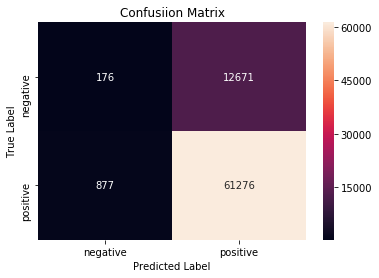

In [79]:
Confusion_Matrix(y_test, pred)

In [81]:
# Feature importance 

pos_feat  = classifier.coef_[:10].argsort()
neg_feat  = classifier.coef_[:10].argsort()

print(np.take(abc.get_feature_names() , neg_feat[:10]))
print(np.take(abc.get_feature_names() , pos_feat[:10]))

[['disappoint' 'worst' 'terribl' ... 'best' 'love' 'great']]
[['disappoint' 'worst' 'terribl' ... 'best' 'love' 'great']]


In [80]:
# Increasing the Hyperparameter and observing changes on Error on train data

In [71]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.001 ,loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy for traning model is', tr_score)

Accuracy for traning model is 0.9494514285714286


In [72]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.050549%


In [73]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=5 ,loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy for traning model is', tr_score)

Accuracy for traning model is 0.8677771428571428


In [74]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.132223%


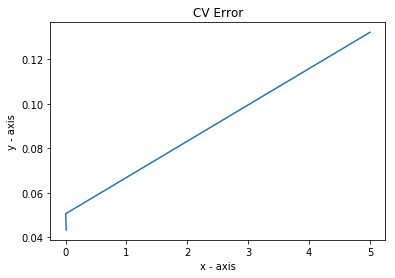

In [82]:
x= [ 0.01 , 0.001 , 5 ]
y= [ 0.043263 , 0.050549 , 0.132223]

# importing the required module 
import matplotlib.pyplot as plt 
  
# plotting the graph of train data error vs hyperparameter alpha
plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('x - axis') 
# naming the y axis 
plt.ylabel('y - axis') 
  
# giving a title to my graph 
plt.title('CV Error') 
  
# function to show the plot 
plt.show() 

### Training the SGDClassifier using Random Search with  L2 - Regularization 

In [26]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [90]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

svm = linear_model.SGDClassifier(loss='hinge')

my_cv = TimeSeriesSplit(n_splits=2).split(X_train)

random_parameters = {'alpha':[10**-2, 10**-1, 1, 10, 100]}

random_parameters = {'alpha':uniform()}
randomSearchModel = RandomizedSearchCV(svm, random_parameters, cv=my_cv)
randomSearchModel.fit(X_train, y_train)
randomSearchModel.best_params_

{'alpha': 0.18760640457318956}

In [98]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.18760640457318956, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.9472285714285714


In [93]:
pred = classifier.predict(x_test)

accuracy = f1_score(y_test, pred , average = 'micro')
print ('Accuracy on test data is ',accuracy)

Accuracy on test data is  0.8401066666666667


In [94]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.053029%


In [95]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

[[  875 11972]
 [   20 62133]]


In [99]:
# Feature importance 

pos_feat  = classifier.coef_[:10].argsort()
neg_feat  = classifier.coef_[:10].argsort()

print(np.take(abc.get_feature_names() , neg_feat[:10]))
print(np.take(abc.get_feature_names() , pos_feat[:10]))

[['disappoint' 'worst' 'terribl' ... 'good' 'love' 'great']]
[['disappoint' 'worst' 'terribl' ... 'good' 'love' 'great']]


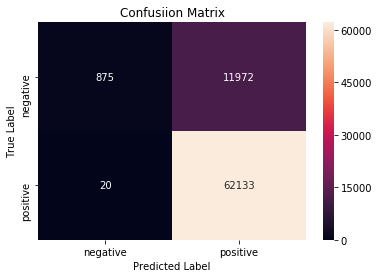

In [96]:
Confusion_Matrix(y_test, pred)

In [ ]:
# Changing the Hyperparameter and observing changes on Error on train data

In [97]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.1, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.9529257142857143


In [100]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.052771%


In [101]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.01, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.9568742857142857


In [102]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.043126%


In [103]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.001, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.9507028571428572


In [104]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.049297%


In [105]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=5, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.8678


In [106]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.132200%


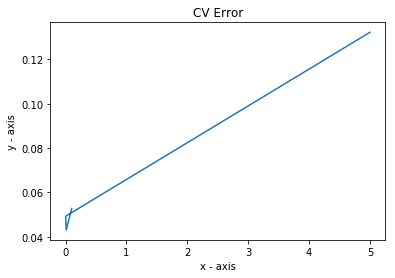

In [108]:
x= [ 0.1 , 0.01 ,0.001, 5 ]
y= [ 0.052771,0.043126 ,0.049297 , 0.132200]

# importing the required module 
import matplotlib.pyplot as plt 
  
# plotting the graph of train data error vs hyperparameter alpha
plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('x - axis') 
# naming the y axis 
plt.ylabel('y - axis') 
  
# giving a title to my graph 
plt.title('CV Error') 
  
# function to show the plot 
plt.show() 

# [7.2.5] TF-IDF

In [240]:
# Considering 250K data samples 

final_60k = final[:250000]

In [241]:
# Sorting data based on time
final_60k["Time"] = pd.to_datetime(final_60k["Time"], unit = "s")
final_60k = final_60k.sort_values(by = "Time")


In [242]:
# Assigning data to X

X = final_60k["CleanedText"]

# Target/class-label

y = final_60k["Score"]

In [243]:
# Spliting the data into train and test such that 70% data will be used to train model and 30% for test purpose.

X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25, shuffle=False)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)


(175000,) (75000,) (175000,) (75000,)


In [244]:
from sklearn.feature_extraction.text import TfidfVectorizer


tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = tf_idf_vect.fit_transform(X_train)
X_train

<175000x1790910 sparse matrix of type '<class 'numpy.float64'>'
	with 11741170 stored elements in Compressed Sparse Row format>

In [245]:
# Convert test text data to its vectorizor

x_test = tf_idf_vect.transform(x_test)
x_test.shape

(75000, 1790910)

In [56]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(x_test)


### Training the SGDClassifier using GridSearchCV with L2 - Regularization

In [46]:
# training the SGDClassifier model , getting the best parameter

svm = linear_model.SGDClassifier(loss='hinge')

my_cv = TimeSeriesSplit(n_splits=2).split(X_train)
grid_parameters = {'alpha':[1, 10, 1000]}
gridSearchModel = GridSearchCV(svm, grid_parameters, cv=my_cv)
gridSearchModel.fit(X_train, y_train)
gridSearchModel.best_params_


{'alpha': 1}

In [326]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=1 ,loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy for traning model is', tr_score)

Accuracy for traning model is 0.9201657142857143


In [328]:
from sklearn.metrics import f1_score
pred = classifier.predict(x_test)

accuracy = f1_score(y_test, pred , average = 'micro')
print ('Accuracy on test data is ',accuracy)

Accuracy on test data is  0.8318399999999999


In [329]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.079834%


In [330]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

[[  227 12609]
 [    3 62161]]


In [54]:
# Function to plot Confusion_Matrix

def Confusion_Matrix(q,w):
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

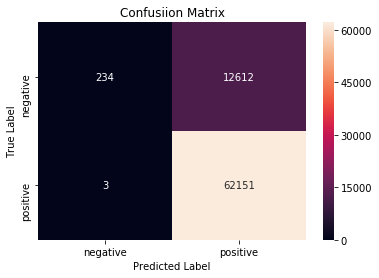

In [64]:
Confusion_Matrix(y_test, pred)

In [50]:
# Feature importance 

pos_feat  = classifier.coef_[:10].argsort()
neg_feat  = classifier.coef_[:10].argsort()

print(np.take(abc.get_feature_names() , neg_feat[:10]))
print(np.take(abc.get_feature_names() , pos_feat[:10]))

[['disappoint' 'return' 'wast' ... 'good' 'love' 'great']]
[['disappoint' 'return' 'wast' ... 'good' 'love' 'great']]


In [ ]:
# Changing the Hyperparameter and observing changes on Error on train data

In [42]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.001, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.9230857142857143


In [43]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.076914%


In [33]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.01, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.8984571428571428


In [34]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.101543%


In [35]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.001, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.9241828571428572


In [36]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.075817%


In [37]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=5, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.8607542857142857


In [38]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.139246%


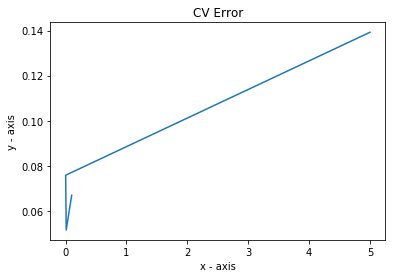

In [44]:
x= [ 0.1 , 0.01 ,0.001, 5 ]
y= [ 0.066914 , 0.051543 ,0.075817 , 0.139246]

# importing the required module 
import matplotlib.pyplot as plt 
  
# plotting the graph of train data error vs hyperparameter alpha
plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('x - axis') 
# naming the y axis 
plt.ylabel('y - axis') 
  
# giving a title to my graph 
plt.title('CV Error') 
  
# function to show the plot 
plt.show() 

### Training the SGDClassifier using Random Search with L2 - Regularization

In [45]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

svm = linear_model.SGDClassifier(loss='hinge')
my_cv = TimeSeriesSplit(n_splits=2).split(X_train)
random_parameters = {'alpha':uniform()}
randomSearchModel = RandomizedSearchCV(svm, random_parameters, cv=my_cv)
randomSearchModel.fit(X_train, y_train)
randomSearchModel.best_params_

{'alpha': 0.0320622028840295}

In [56]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha= 0.00320622028840295, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.9112228571428571


In [57]:
pred = classifier.predict(x_test)

accuracy = f1_score(y_test, pred , average = 'micro')
print ('Accuracy on test data is ',accuracy)

Accuracy on test data is  0.8939733333333333


In [58]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.088777%


In [59]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

[[ 5549  7297]
 [  655 61499]]


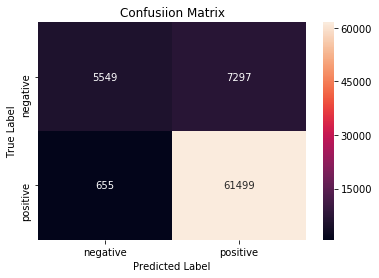

In [62]:
Confusion_Matrix(y_test, pred)

In [63]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha= 0.1, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.8612


In [64]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.138800%


In [65]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha= 0.01, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.8961371428571429


In [66]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.103863%


In [67]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha= 0.001, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.9241428571428572


In [68]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.075857%


In [69]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha= 5, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.8607542857142857


In [70]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.139246%


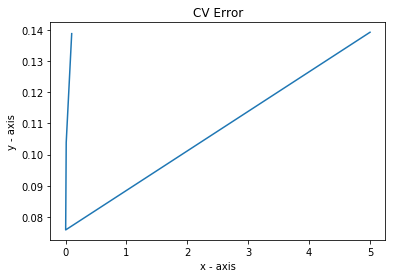

In [71]:
x= [ 0.1 , 0.01 ,0.001, 5 ]
y= [ 0.138800 , 0.103863 ,0.075857, 0.139246]

# importing the required module 
import matplotlib.pyplot as plt 
  
# plotting the graph of train data error vs hyperparameter alpha
plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('x - axis') 
# naming the y axis 
plt.ylabel('y - axis') 
  
# giving a title to my graph 
plt.title('CV Error') 
  
# function to show the plot 
plt.show() 

## Avg Word2Vec

In [208]:
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle =False)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(175000,) (75000,) (175000,) (75000,)


In [209]:
import re

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [210]:
# Train your own Word2Vec model using your own train text corpus
import gensim
list_of_sent=[]
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [211]:
# Train your own Word2Vec model using your own test text corpus
import gensim
list_of_sent_test = []
#for sent in final_40k['Text'].values:
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [212]:
# min_count = 5 considers only words that occured atleast 5 times

w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [213]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

175000
50


In [214]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

75000
50


In [215]:
X_train = sent_vectors

In [216]:
x_test = sent_vectors_test

In [217]:
X_train = np.nan_to_num(X_train)

In [218]:
x_test = np.nan_to_num(x_test)

### Training the SGDClassifier using GridSearchCV with L2 - Regularization

In [144]:
# training the SGDClassifier model , getting the best parameter

svm = linear_model.SGDClassifier(loss='hinge')

my_cv = TimeSeriesSplit(n_splits=2).split(X_train)

grid_parameters = {'alpha':[10**-2, 10**-1, 1, 10, 100]}
gridSearchModel = GridSearchCV(svm, grid_parameters, cv=my_cv)
gridSearchModel.fit(X_train, y_train)
gridSearchModel.best_params_


{'alpha': 0.01}

In [145]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=gridSearchModel.best_params_['alpha'] ,loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy for traning model is', tr_score)

Accuracy for traning model is 0.8903142857142857


In [146]:
pred = classifier.predict(x_test)

accuracy = f1_score(y_test, pred , average = 'micro')
print ('Accuracy on test data is ',accuracy)

Accuracy on test data is  0.86952


In [147]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.109686%


In [148]:
# Feature importance 

pos_feat  = classifier.coef_[:10].argsort()
neg_feat  = classifier.coef_[:10].argsort()

print(np.take(abc.get_feature_names() , neg_feat[:10]))
print(np.take(abc.get_feature_names() , pos_feat[:10]))

[['aagh' 'aaaaaaaaagghh' 'aaah' 'aback' 'aaaaah' 'abat' 'abandn' 'aaagh'
  'aaa' 'aaaaaahhhhhyaaaaaa' 'aaaand' 'aachen' 'aaaaawsom' 'aa' 'aarrgh'
  'aaaaahhhhhhhhhhhhhhhh' 'aand' 'ab' 'aap' 'aadp' 'aah' 'abaolut'
  'aaaaaaarrrrrggghhh' 'abattoir' 'abba' 'aaf' 'abalon' 'abandon'
  'abamectin' 'aalmost' 'aahh' 'aardvark' 'aaaaaand' 'aafter' 'aaaaaahhh'
  'aacur' 'aad' 'abbazabba' 'aaaaaahhhh' 'aani' 'aamzon' 'aaahhhhhh'
  'aar' 'aaaahhhhhh' 'aaaah' 'aafco' 'aamazon' 'aaaa' 'aaahhh'
  'aaaaaaaaaaaaaaaaaaaargh']]
[['aagh' 'aaaaaaaaagghh' 'aaah' 'aback' 'aaaaah' 'abat' 'abandn' 'aaagh'
  'aaa' 'aaaaaahhhhhyaaaaaa' 'aaaand' 'aachen' 'aaaaawsom' 'aa' 'aarrgh'
  'aaaaahhhhhhhhhhhhhhhh' 'aand' 'ab' 'aap' 'aadp' 'aah' 'abaolut'
  'aaaaaaarrrrrggghhh' 'abattoir' 'abba' 'aaf' 'abalon' 'abandon'
  'abamectin' 'aalmost' 'aahh' 'aardvark' 'aaaaaand' 'aafter' 'aaaaaahhh'
  'aacur' 'aad' 'abbazabba' 'aaaaaahhhh' 'aani' 'aamzon' 'aaahhhhhh'
  'aar' 'aaaahhhhhh' 'aaaah' 'aafco' 'aamazon' 'aaaa' 'aaahhh'


In [149]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

[[ 3727  9114]
 [  672 61487]]


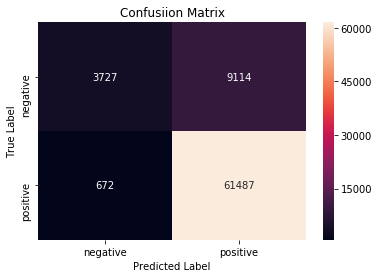

In [150]:
Confusion_Matrix(y_test, pred)

In [151]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.1 ,loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy for traning model is', tr_score)

Accuracy for traning model is 0.8607257142857143


In [152]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.139274%


In [153]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.01 ,loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy for traning model is', tr_score)

Accuracy for traning model is 0.8900742857142857


In [154]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.109926%


In [155]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.001 ,loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy for traning model is', tr_score)

Accuracy for traning model is 0.9000628571428572


In [156]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.099937%


In [157]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=5 ,loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy for traning model is', tr_score)

Accuracy for traning model is 0.8607257142857143


In [158]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.139274%


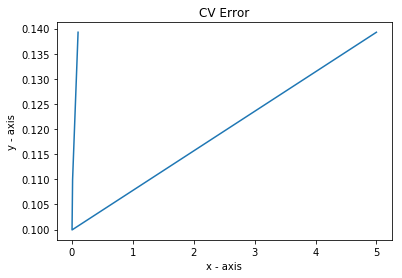

In [159]:
x= [ 0.1 , 0.01 ,0.001, 5 ]
y= [ 0.139274, 0.109926 ,0.099937, 0.139274]

# importing the required module 
import matplotlib.pyplot as plt 
  
# plotting the graph of train data error vs hyperparameter alpha
plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('x - axis') 
# naming the y axis 
plt.ylabel('y - axis') 
  
# giving a title to my graph 
plt.title('CV Error') 
  
# function to show the plot 
plt.show() 

### Training the SGDClassifier using Random Search with L2 - Regularization

In [160]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

svm = linear_model.SGDClassifier(loss='hinge')
my_cv = TimeSeriesSplit(n_splits=2).split(X_train)
random_parameters = {'alpha':uniform()}
randomSearchModel = RandomizedSearchCV(svm, random_parameters, cv=my_cv)
randomSearchModel.fit(X_train, y_train)
randomSearchModel.best_params_

{'alpha': 0.10698436250939469}

In [332]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=randomSearchModel.best_params_['alpha'], loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.9243542857142857


In [333]:
pred = classifier.predict(x_test)

accuracy = f1_score(y_test, pred , average = 'micro')
print ('Accuracy on test data is ',accuracy)

Accuracy on test data is  0.83284


In [334]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.075646%


In [164]:
# Feature importance 

pos_feat  = classifier.coef_[:10].argsort()
neg_feat  = classifier.coef_[:10].argsort()

print(np.take(abc.get_feature_names() , neg_feat[:10]))
print(np.take(abc.get_feature_names() , pos_feat[:10]))

[['aagh' 'aaaaaaaaagghh' 'aaah' 'aback' 'abandn' 'aaaaah' 'aaagh' 'abat'
  'aaa' 'aaaaaahhhhhyaaaaaa' 'aaaand' 'aaaaawsom' 'aachen' 'aa' 'aarrgh'
  'aaaaahhhhhhhhhhhhhhhh' 'aand' 'aap' 'aah' 'ab' 'abaolut' 'abattoir'
  'aadp' 'aaaaaaarrrrrggghhh' 'abalon' 'aaf' 'abamectin' 'abba' 'abandon'
  'aalmost' 'aahh' 'aafter' 'aaaaaand' 'aacur' 'aardvark' 'aaaaaahhh'
  'aad' 'aaaaaahhhh' 'abbazabba' 'aamzon' 'aani' 'aaahhhhhh' 'aar'
  'aaaahhhhhh' 'aaaah' 'aafco' 'aaaa' 'aamazon' 'aaahhh'
  'aaaaaaaaaaaaaaaaaaaargh']]
[['aagh' 'aaaaaaaaagghh' 'aaah' 'aback' 'abandn' 'aaaaah' 'aaagh' 'abat'
  'aaa' 'aaaaaahhhhhyaaaaaa' 'aaaand' 'aaaaawsom' 'aachen' 'aa' 'aarrgh'
  'aaaaahhhhhhhhhhhhhhhh' 'aand' 'aap' 'aah' 'ab' 'abaolut' 'abattoir'
  'aadp' 'aaaaaaarrrrrggghhh' 'abalon' 'aaf' 'abamectin' 'abba' 'abandon'
  'aalmost' 'aahh' 'aafter' 'aaaaaand' 'aacur' 'aardvark' 'aaaaaahhh'
  'aad' 'aaaaaahhhh' 'abbazabba' 'aamzon' 'aani' 'aaahhhhhh' 'aar'
  'aaaahhhhhh' 'aaaah' 'aafco' 'aaaa' 'aamazon' 'aaahhh'


In [335]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

[[  302 12534]
 [    3 62161]]


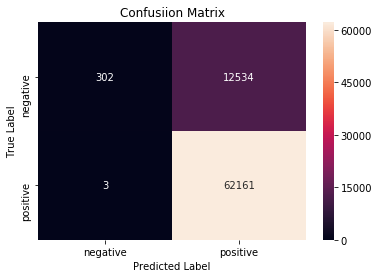

In [336]:
Confusion_Matrix(y_test, pred)

In [119]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.1, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.8607257142857143


In [120]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.139274%


In [121]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.01, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.8893771428571429


In [122]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.110623%


In [123]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.001, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.8999542857142857


In [124]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.100046%


In [125]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=5, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.8607257142857143


In [126]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.139274%


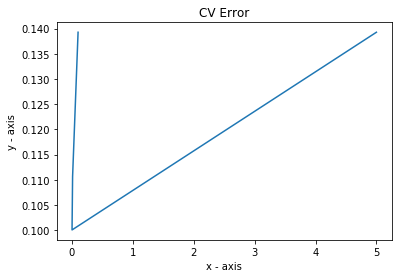

In [128]:
x= [0.1, 0.01 , 0.001, 5]
y= [0.139274 , 0.110623,0.100046 ,0.139274]

# importing the required module 
import matplotlib.pyplot as plt 
  
# plotting the graph of train data error vs hyperparameter alpha
plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('x - axis') 
# naming the y axis 
plt.ylabel('y - axis') 
  
# giving a title to my graph 
plt.title('CV Error') 
  
# function to show the plot 
plt.show() 

### Avg W2V, TFIDF-W2V

In [246]:
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(175000,) (75000,) (175000,) (75000,)


In [247]:
from sklearn.feature_extraction.text import TfidfVectorizer

#tfidf = TfidfVectorizer()
#tfidf_data = tfidf.fit_transform(final_4000["CleanedText"])
#tfidf_data
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = tf_idf_vect.fit_transform(X_train)
X_train

<175000x1790910 sparse matrix of type '<class 'numpy.float64'>'
	with 11741170 stored elements in Compressed Sparse Row format>

In [248]:
# Convert test text data to its vectorizor
x_test = tf_idf_vect.transform(x_test)
x_test.shape

(75000, 1790910)

In [249]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1  

In [250]:
X_train = tfidf_sent_vectors

In [251]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1  

In [252]:
x_test = tfidf_sent_vectors_test

In [253]:
X_train = np.nan_to_num(X_train)

In [254]:
x_test = np.nan_to_num(x_test)

### Training the SGDClassifier using GridSearchCV with L2 - Regularization

In [219]:
# training the SGDClassifier model , getting the best parameter

svm = linear_model.SGDClassifier(loss='hinge')

my_cv = TimeSeriesSplit(n_splits=2).split(X_train)
grid_parameters = {'alpha':[1, 10, 100]}
gridSearchModel = GridSearchCV(svm, grid_parameters, cv=my_cv)
gridSearchModel.fit(X_train, y_train)
gridSearchModel.best_params_


{'alpha': 1}

In [50]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.0001, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.9478


In [51]:
from sklearn.metrics import f1_score
pred = classifier.predict(x_test)

accuracy = f1_score(y_test, pred , average = 'micro')
print ('Accuracy on test data is ',accuracy)

Accuracy on test data is  0.8857733333333333


In [52]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.052200%


In [53]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

[[ 4972  7874]
 [  693 61461]]


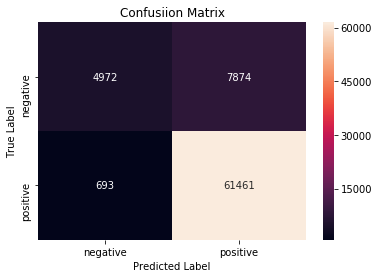

In [55]:
Confusion_Matrix(y_test, pred)

In [188]:
# Feature importance 

pos_feat  = classifier.coef_[:10].argsort()
neg_feat  = classifier.coef_[:10].argsort()

print(np.take(abc.get_feature_names() , neg_feat[:10]))
print(np.take(abc.get_feature_names() , pos_feat[:10]))

[['aa' 'aagh' 'aah' 'aahh' 'aalmost' 'aamazon' 'aamzon' 'aand' 'aani'
  'aap' 'aar' 'aardvark' 'aarrgh' 'ab' 'aback' 'abalon' 'abamectin'
  'abandn' 'abandon' 'abaolut' 'abat' 'abattoir' 'aafter' 'aafco' 'aaf'
  'aadp' 'aaa' 'aaaa' 'aaaaaaaaaaaaaaaaaaaargh' 'aaaaaaaaagghh'
  'aaaaaaarrrrrggghhh' 'aaaaaahhh' 'aaaaaahhhh' 'aaaaaahhhhhyaaaaaa'
  'aaaaaand' 'aaaaah' 'abba' 'aaaaahhhhhhhhhhhhhhhh' 'aaaah' 'aaaahhhhhh'
  'aaaand' 'aaagh' 'aaah' 'aaahhh' 'aaahhhhhh' 'aachen' 'aacur' 'aad'
  'aaaaawsom' 'abbazabba']]
[['aa' 'aagh' 'aah' 'aahh' 'aalmost' 'aamazon' 'aamzon' 'aand' 'aani'
  'aap' 'aar' 'aardvark' 'aarrgh' 'ab' 'aback' 'abalon' 'abamectin'
  'abandn' 'abandon' 'abaolut' 'abat' 'abattoir' 'aafter' 'aafco' 'aaf'
  'aadp' 'aaa' 'aaaa' 'aaaaaaaaaaaaaaaaaaaargh' 'aaaaaaaaagghh'
  'aaaaaaarrrrrggghhh' 'aaaaaahhh' 'aaaaaahhhh' 'aaaaaahhhhhyaaaaaa'
  'aaaaaand' 'aaaaah' 'abba' 'aaaaahhhhhhhhhhhhhhhh' 'aaaah' 'aaaahhhhhh'
  'aaaand' 'aaagh' 'aaah' 'aaahhh' 'aaahhhhhh' 'aachen' 'aacur' 'aad

In [224]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.1, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.8607257142857143


In [225]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.139274%


In [226]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.001, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.8985085714285714


In [227]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.101491%


In [228]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.0001, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.8932457142857143


In [232]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.139274%


In [230]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=5, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.8607257142857143


In [231]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.139274%


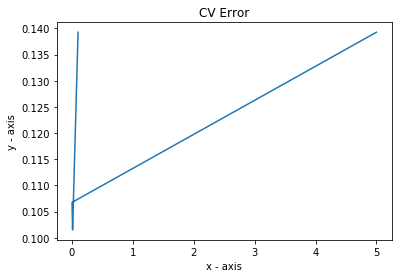

In [233]:
x= [0.1, 0.01 , 0.001, 5]
y= [0.139274 , 0.101491,0.106754 ,0.139274]

# importing the required module 
import matplotlib.pyplot as plt 
  
# plotting the graph of train data error vs hyperparameter alpha
plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('x - axis') 
# naming the y axis 
plt.ylabel('y - axis') 
  
# giving a title to my graph 
plt.title('CV Error') 
  
# function to show the plot 
plt.show() 

### Training the SGDClassifier using Random Search with L2 - Regularization

In [234]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

svm = linear_model.SGDClassifier(loss='hinge')
my_cv = TimeSeriesSplit(n_splits=2).split(X_train)

random_parameters = {'alpha':uniform()}
randomSearchModel = RandomizedSearchCV(svm, random_parameters, cv=my_cv)
randomSearchModel.fit(X_train, y_train)
randomSearchModel.best_params_

{'alpha': 0.851786088103048}

In [61]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.01, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.9568457142857143


In [62]:
pred = classifier.predict(x_test)

accuracy = f1_score(y_test, pred , average = 'micro')
print ('Accuracy on test data is ',accuracy)

Accuracy on test data is  0.8590266666666667


In [63]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.043154%


In [64]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

[[ 2394 10452]
 [  121 62033]]


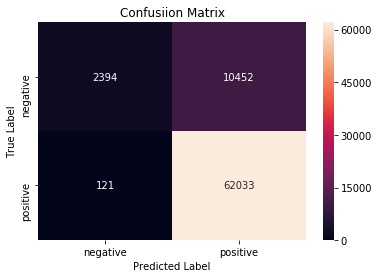

In [65]:
Confusion_Matrix(y_test, pred)

In [137]:
# Feature importance 

pos_feat  = classifier.coef_[:10].argsort()
neg_feat  = classifier.coef_[:10].argsort()

print(np.take(abc.get_feature_names() , neg_feat[:10]))
print(np.take(abc.get_feature_names() , pos_feat[:10]))

[['aa' 'aacur' 'aadp' 'aaf' 'aafco' 'aafter' 'aagh' 'aah' 'aamazon'
  'aamzon' 'aana' 'aand' 'aani' 'aardvark' 'aarp' 'aarrgh' 'aarthur' 'ab'
  'aback' 'abalon' 'abamectin' 'abandon' 'aachen' 'aabsolut' 'aaahhhhhh'
  'aaahhh' 'aaa' 'aaaa' 'aaaaa'
  'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'
  'aaaaaaaaaaaaaaaaaaaargh' 'aaaaaaaaagghh' 'aaaaaaahhhhhh'
  'aaaaaaarrrrrggghhh' 'aaaaaahhh' 'aaaaaahhhh' 'abaolut'
  'aaaaaahhhhhyaaaaaa' 'aaaaaawwwwwwwwww' 'aaaaah'
  'aaaaahhhhhhhhhhhhhhhh' 'aaaaawsom' 'aaaah' 'aaaahhhhhh' 'aaaallll'
  'aaaand' 'aaagh' 'aaah' 'aaaaaand' 'abat']]
[['aa' 'aacur' 'aadp' 'aaf' 'aafco' 'aafter' 'aagh' 'aah' 'aamazon'
  'aamzon' 'aana' 'aand' 'aani' 'aardvark' 'aarp' 'aarrgh' 'aarthur' 'ab'
  'aback' 'abalon' 'abamectin' 'abandon' 'aachen' 'aabsolut' 'aaahhhhhh'
  'aaahhh' 'aaa' 'aaaa' 'aaaaa'
  'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'
  'aaaaaaaaaaaaaaaaaaaargh' 'aaaaaaaaagghh' 'aaaaaaahhhhhh'
  'aaaaaaarrrrrggghhh' 'aaaaaahhh' 'aaaaaahhhh' 'abaolut'
  'aa

In [279]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.1, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.9525885714285715


In [280]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.047411%


In [281]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.01, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.9565657142857142


In [282]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.043434%


In [283]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=0.001, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.9511028571428571


In [284]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.048897%


In [285]:
classifier = linear_model.SGDClassifier(penalty='l2', alpha=5, loss='hinge')
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.8677542857142857


In [286]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.132246%


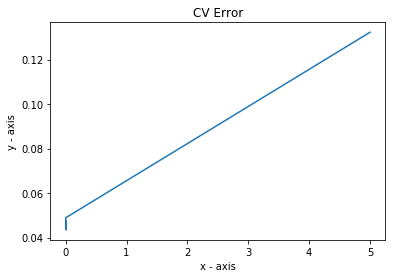

In [288]:
x= [ 0 , 0.01, 0.001 , 5]
y= [ 0.047411,0.043434,0.048897 ,0.132246]

# importing the required module 
import matplotlib.pyplot as plt 
  
# plotting the graph of train data error vs hyperparameter alpha
plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('x - axis') 
# naming the y axis 
plt.ylabel('y - axis') 
  
# giving a title to my graph 
plt.title('CV Error') 
  
# function to show the plot 
plt.show() 

## Performing SVC on BOG

In [313]:
from sklearn.svm import SVC

### Using Gridsearch CV

In [314]:
# training the SVM model , getting the best parameter

svm_bog = SVC(kernel='rbf')

grid_parameters = {'gamma':[10**-2, 10**-1, 1, 10, 100]}
my_cv = TimeSeriesSplit(n_splits=2).split(X_train)
gridSearchModel = GridSearchCV(svm_bog, grid_parameters, cv=my_cv)
gridSearchModel.fit(X_train, y_train)
gridSearchModel.best_params_

{'gamma': 0.01}

In [148]:
classifier = SVC(gamma = 0.01)
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.94746


In [149]:
pred = classifier.predict(x_test)

accuracy = f1_score(y_test, pred , average = 'micro')
print ('Accuracy on test data is ',accuracy)

Accuracy on test data is  0.9137866666666666


In [152]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.052540%


In [150]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

[[ 5442  5643]
 [  823 63092]]


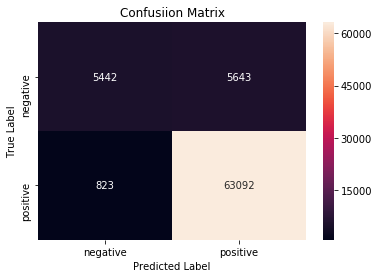

In [151]:
Confusion_Matrix(y_test, pred)

### Using Random search CV

In [41]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

svm_bog = SVC(kernel='rbf')
my_cv = TimeSeriesSplit(n_splits=2).split(X_train)
random_parameters = {'gamma':uniform()}
randomSearchModel = RandomizedSearchCV(svm_bog, random_parameters, cv=my_cv)
randomSearchModel.fit(X_train, y_train)
randomSearchModel.best_params_

{'gamma': 0.05489520558343397}

In [55]:
classifier = SVC(gamma = 0.05489520558343397)
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy on traning data is ' , tr_score)

Accuracy on traning data is  0.9872


In [56]:
# Error on train data
train_err_bow = 1-tr_score
print("Train Error %f%%" % (train_err_bow))

Train Error 0.012800%


In [57]:
pred = classifier.predict(x_test)

accuracy = metrics.accuracy_score(y_test, pred)
print ('Accuracy on test data is ',accuracy)

Accuracy on test data is  0.8650933333333334


In [45]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

[[ 1200  9973]
 [  123 63704]]


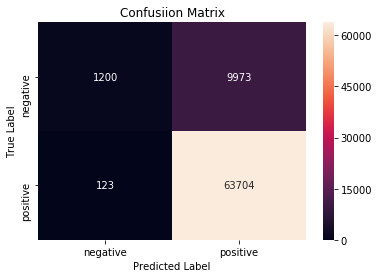

In [46]:
Confusion_Matrix(y_test, pred)

In [16]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Method", " SGDClassifier(hinge_loss) Algorithm with " ,  "Accuracy"]

x.add_row(["BOG", 'GridSearchCV ',  '0.86905'])
x.add_row(["BOG", 'Random Search  ', '0.84010'])

x.add_row(["TFIDF", 'GridSearchCV ',   '0.83183'])
x.add_row(["TFIDF", ' Random Search ','0.89397'])

x.add_row(["W2V",'GridSearchCV' , '0.86952'])
x.add_row(["W2V",'Random Search' ,'0.83284'])

x.add_row(["TFIDF - W2V",'GridSearchCV' ,  '0.88572'])
x.add_row(["TFIDF - W2V",'Random Search' , '0.85902'])

x.add_row(["SVC",'GridSearchCV' ,  '0.91372'])
x.add_row(["SVC",'Random Search' , '0.86509'])


print(x)

+-------------+--------------------------------------------+----------+
|    Method   |  SGDClassifier(hinge_loss) Algorithm with  | Accuracy |
+-------------+--------------------------------------------+----------+
|     BOG     |               GridSearchCV                 | 0.86905  |
|     BOG     |              Random Search                 | 0.84010  |
|    TFIDF    |               GridSearchCV                 | 0.83183  |
|    TFIDF    |               Random Search                | 0.89397  |
|     W2V     |                GridSearchCV                | 0.86952  |
|     W2V     |               Random Search                | 0.83284  |
| TFIDF - W2V |                GridSearchCV                | 0.88572  |
| TFIDF - W2V |               Random Search                | 0.85902  |
|     SVC     |                GridSearchCV                | 0.91372  |
|     SVC     |               Random Search                | 0.86509  |
+-------------+--------------------------------------------+----

# Observations : - 


#### All of the above results with different technique of BOG, TFIDF,W2V, TFIDF-W2v varys for L2 regulization with both GridSearchCV & Random Search,  for SGDClassifier(hinge_loss) Algorithm  algorithm. Out of all of , SVC  with  GridSearchCV - L2 gives us highest accuracy of aprox 91.37%